In [1]:
from _collections_abc import Iterable
from functools import cached_property
import numpy as np
from matplotlib import pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical

# Implementation

In [3]:
class DenseLayer:
    def __init__(self,
                 n_in: int,
                 n_neu: int,
                 activation_function: str):
        self.activ_name = activation_function
        self.n_in = n_in
        self.n_out = n_neu
        self.weights = 2*np.random.random((n_neu, n_in+1))-1

    @cached_property
    def activ_func(self):
        activ_func_dict = {'sigmoid': lambda x: np.exp(x) / (1 + np.exp(x)),
                           'exponential': lambda x: np.exp(x),
                           'relu': lambda x: max((x,0)),
                           'softmax': lambda x: np.asarray([np.exp(i) / sum(np.exp(x)) for i in x])}
        func = activ_func_dict.get(self.activ_name)
        if not self.activ_name=='softmax':
            func = np.vectorize(func)
        return func
    
    @cached_property
    def d_activ_func(self):
        activ_func_dict = {'sigmoid': lambda x: np.exp(x) / (1 + np.exp(x))**2,
                           'exponential': lambda x: np.exp(x),
                           'relu': lambda x: (x>0)*1}
        func = activ_func_dict.get(self.activ_name)
        if not self.activ_name=='softmax':
            func = np.vectorize(func)
        return func
    
    def init_weights(self):
        if self.activ_name in ('sigmoid', 'relu'):
            w = np.random.normal(0, 2/(self.n_in+self.n_out), size=(self.n_out, self.n_in))
        else:
            w = np.sqrt(6)*(2*np.random.random((self.n_out, self.n_in))-1)/np.sqrt(self.n_out+self.n_in)
        self.weights = np.c_[np.zeros(self.n_out), w]

    def forward_prop(self, input):
        self.input = np.vstack((1, input))
        self.out =  self.weights @ self.input
        return self.activ_func(self.out)
    
    def back_prop(self, output, dlda,  learning_rate: float):
        self.delta = dlda if self.activ_name=='softmax' else dlda * self.d_activ_func(output)
        self.result =  self.delta * self.input.reshape(1,-1)
        res = self.weights.T @ self.delta
        self.weights -= learning_rate * self.result
        return res

class NeuralNetwork:
    def __init__(self, loss_function='mse'): 
        self.layers = []
        self.loss_name = loss_function
    
    def add_layer(self,
                  n_in,
                  n_neu: int,
                  activation_function: str):
        '''
        Add layer to the model

        @n_in: (int) number of input neurons for this layer
        @n_neu: (int) number of output neurons for this layer
        @activation_function: (str) name of the activation function
        '''
        self.layers.append(DenseLayer(n_in, n_neu, activation_function))

    @cached_property
    def loss_func(self):
        loss_func_dict = {'mse': lambda x: np.mean((x[0]-x[1])**2), #x[0]-true label
                          'categorical_crossentropy': lambda x: -sum(x[0]*np.log(x[1]))}
        return loss_func_dict.get(self.loss_name)
    
    @cached_property
    def d_loss_func(self):
        loss_func_dict = {'mse': lambda x: 2*(x[1]-x[0])/x[0].size, #x[0]-true label
                          'categorical_crossentropy': lambda x: sum(x[0])*x[1]-x[0]}
        return loss_func_dict.get(self.loss_name)

    def fit(self, train_features: np.array, train_targets: np.array, epochs: int, learning_rate: float, val: Iterable[np.array] =None):
        '''
        Fit model to the given data

        @train_features: (np.array) array to fit the model to
        @train_targets: (np.array) array to verify the fit
        @epochs: (int) number of epochs for a model to be trained for
        @learning_rate: (float) number defining learning rate
        @val: (Iterable[np.array]) validation set in the form (validation_features, validation_targets),
                                    - model doesn't learn based on this [parameter], 
                                    default None (meaning the feature is not used)
        '''

        self.loss = []
        self.acc = []
        train_features = train_features.copy()
        train_targets = train_targets.copy()
        if val:
            self.val_loss = []
            self.val_acc = []
        for i in range(epochs):
            loss=0
            order = np.arange(train_features.shape[0])
            np.random.shuffle(order)
            train_features = train_features[order,:]
            train_targets = train_targets[order,:]
            for j in range(train_features.shape[0]):
                train = train_features[j,:].reshape(train_features[j,:].size,1)
                layer_out = train
                for layer in self.layers:
                    layer_out = layer.forward_prop(layer_out)
                targets = train_targets[j,:].reshape(train_targets[j,:].size,1)
                loss += self.loss_func((targets,layer_out))

                dlda = self.d_loss_func((targets,layer_out))
                for layer in self.layers[::-1]:
                    dlda = layer.back_prop(layer.out, dlda, learning_rate)[1:]
            self.set_learning_state(train_features, train_targets, val, epoch=i)
    
    def set_learning_state(self, x_train, y_train, val, epoch):
        self.predict(x_train, y_train)
        self.loss.append(self.test_loss)
        self.acc.append(self.test_acc)
        print(f'epoch: {epoch+1}, loss: {self.loss[-1]}, acc: {self.acc[-1]}')
        if val:
            self.predict(val[0], val[1])
            self.val_loss.append(self.test_loss)
            self.val_acc.append(self.test_acc)
            print(f'val_loss: {self.val_loss[-1]}, val_acc: {self.val_acc[-1]}')
            

    def predict(self, test_features: np.array, test_targets: np.array):
        '''
        Calculate loss and accuracy for prediction based on given test data

        @test_features: (np.array) array to use the model on
        @test_targets: (np.array) array with true values to check loss and accuracy
        '''
        test_acc = []
        test = test_features.copy()
        self.test_loss = 0
        for j in range(test.shape[0]):
            layer_out = test[j,:].reshape(test[j,:].size, 1)
            for layer in self.layers:
                layer_out = layer.forward_prop(layer_out)
            target = test_targets[j,:].reshape(test_targets[j,:].size,1)
            test_acc.append(np.argmax(target)==np.argmax(layer_out))
            self.test_loss += self.loss_func((target,layer_out))
        self.test_acc = np.mean(test_acc)
        self.test_loss /= test.shape[0]

def create_neu_network(neu_list: Iterable[int], activ_func_list: Iterable[str], loss_func: str = 'mse'):
    '''
    Create NeuralNetwork object from given parameters:

    @neu_list: (Iterable[int]) collection of neuron numbers in the order of layers
    @activ_func_list: (Iterable[str]) collection of activation functions in the order of layers
    @loss: (str) name of the loss function, default 'mse'

    return NeuralNetwork object with specified layers
    '''
    if len(neu_list)-1 != len(activ_func_list):
        raise ValueError(f'Incompatible list lengths: neu_list ({len(neu_list)}) and activ_func_list ({len(activ_func_list)})')
    neu_net = NeuralNetwork(loss_function=loss_func)
    for i in range(len(neu_list)-1):
        neu_net.add_layer(neu_list[i], neu_list[i+1], activ_func_list[i])
    return neu_net


# Data preparation

In [4]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))#[:1000,]
train_images = (train_images.astype('float32') / 255)
test_images = test_images.reshape((10000, 28 * 28))#[:1000,]
test_images = (test_images.astype('float32') / 255)


In [5]:
train_images.shape

(60000, 784)

In [6]:
train_labels = to_categorical(train_labels)#[:1000,]
test_labels = to_categorical(test_labels)#[:1000,]

# Models

## First model

In [7]:
first_network = NeuralNetwork('categorical_crossentropy')
first_network.add_layer(28*28, 128,'relu')
first_network.add_layer(128, 10,'softmax')

In [8]:
#lista liczb neuronów i żeby samo się utworzyło
#zbiór obserwacji podzielić na wsady (2**... czy po sto), po każdej liczymy gradient ale wagi updatujemy na koniec, rozmiar batcha żeby się dało podać (ostatni batch to to zostało jak zbiór się nie dZieli)
#funkcja aktywacji czy funkcja kosztu do wyboru
first_network.fit(train_images, train_labels, epochs=10, learning_rate=.01, val=(test_images, test_labels))

epoch: 1, loss: [0.23080881], acc: 0.9343666666666667
val_loss: [0.26144226], val_acc: 0.9296
epoch: 2, loss: [0.16357278], acc: 0.9516
val_loss: [0.2163915], val_acc: 0.9415
epoch: 3, loss: [0.11808224], acc: 0.9640666666666666
val_loss: [0.17517872], val_acc: 0.9531
epoch: 4, loss: [0.10859965], acc: 0.96785
val_loss: [0.19231565], val_acc: 0.9517
epoch: 5, loss: [0.09587611], acc: 0.9712
val_loss: [0.18407344], val_acc: 0.9548
epoch: 6, loss: [0.06905058], acc: 0.9793
val_loss: [0.16407851], val_acc: 0.959
epoch: 7, loss: [0.06000231], acc: 0.9812833333333333
val_loss: [0.16413426], val_acc: 0.9628
epoch: 8, loss: [0.05055294], acc: 0.9841
val_loss: [0.16825327], val_acc: 0.9643
epoch: 9, loss: [0.04359007], acc: 0.9863166666666666
val_loss: [0.17148153], val_acc: 0.9646
epoch: 10, loss: [0.0402511], acc: 0.9864166666666667
val_loss: [0.17485507], val_acc: 0.9624


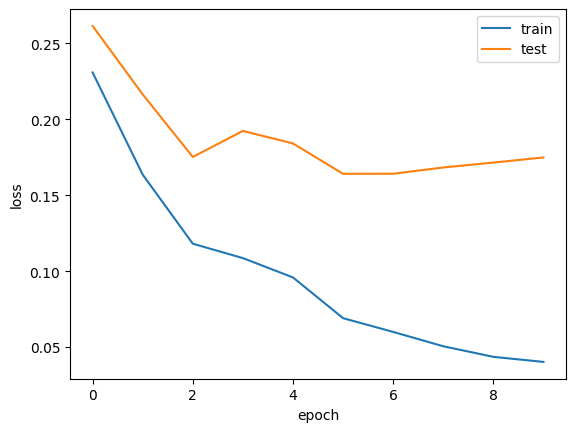

In [23]:
plt.plot(first_network.loss, label='train')
plt.plot(first_network.val_loss, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

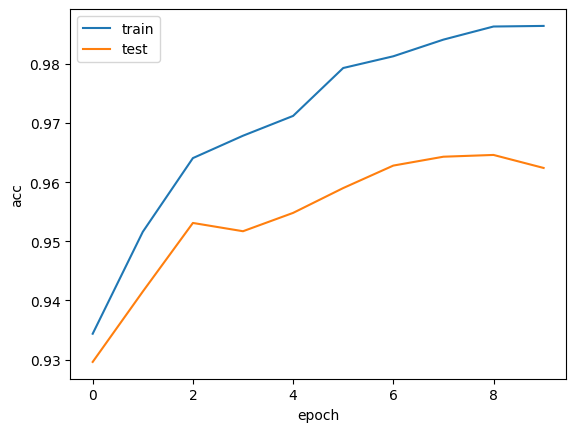

In [24]:
plt.plot(first_network.acc, label='train')
plt.plot(first_network.val_acc, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

In [11]:
first_network.predict(test_images, test_labels)
first_network.test_acc

0.9624

In [12]:
first_network.test_loss

array([0.17485507])

## Second model

In [13]:
second_network = NeuralNetwork('categorical_crossentropy')
second_network.add_layer(28*28, 128,'relu')
second_network.add_layer(128, 64,'sigmoid')
second_network.add_layer(64, 10,'softmax')

In [14]:
second_network.fit(train_images, train_labels, epochs=10, learning_rate=.01, val=(test_images, test_labels))


epoch: 1, loss: [0.30667049], acc: 0.9080666666666667
val_loss: [0.30038577], val_acc: 0.9096
epoch: 2, loss: [0.24260967], acc: 0.9270166666666667
val_loss: [0.24735288], val_acc: 0.9255
epoch: 3, loss: [0.19542597], acc: 0.9430166666666666
val_loss: [0.21598508], val_acc: 0.935
epoch: 4, loss: [0.16333303], acc: 0.9516166666666667
val_loss: [0.18859245], val_acc: 0.9439
epoch: 5, loss: [0.14865295], acc: 0.9559333333333333
val_loss: [0.18545242], val_acc: 0.945
epoch: 6, loss: [0.12969338], acc: 0.9603
val_loss: [0.16938656], val_acc: 0.9498
epoch: 7, loss: [0.11236568], acc: 0.9661666666666666
val_loss: [0.15823695], val_acc: 0.952
epoch: 8, loss: [0.11063339], acc: 0.9654833333333334
val_loss: [0.16031969], val_acc: 0.95
epoch: 9, loss: [0.09207868], acc: 0.9729666666666666
val_loss: [0.14021742], val_acc: 0.9578
epoch: 10, loss: [0.09348995], acc: 0.97215
val_loss: [0.14093415], val_acc: 0.9591


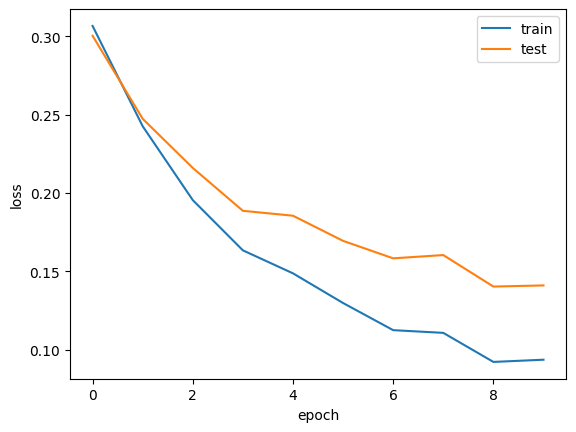

In [15]:
plt.plot(second_network.loss, label='train')
plt.plot(second_network.val_loss, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

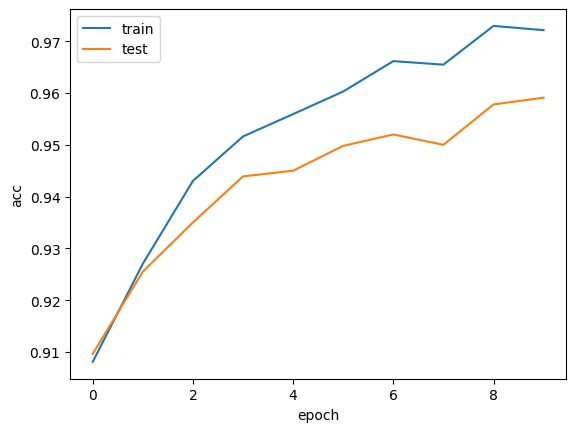

In [16]:
plt.plot(second_network.acc, label='train')
plt.plot(second_network.val_acc, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

## Third model

In [17]:
third_network = NeuralNetwork('mse')
third_network.add_layer(28*28, 128,'relu')
third_network.add_layer(128, 64,'sigmoid')
third_network.add_layer(64, 10,'softmax')

In [18]:
third_network.fit(train_images, train_labels, epochs=10, learning_rate=.01, val=(test_images, test_labels))


epoch: 1, loss: 0.023002362436046357, acc: 0.8430833333333333
val_loss: 0.02245317411238264, val_acc: 0.8463
epoch: 2, loss: 0.016739533280983262, acc: 0.8868666666666667
val_loss: 0.016712330441200497, val_acc: 0.8901
epoch: 3, loss: 0.014309416324519306, acc: 0.9041
val_loss: 0.014751773661842427, val_acc: 0.9005
epoch: 4, loss: 0.012436004385900342, acc: 0.9177166666666666
val_loss: 0.013318170381492706, val_acc: 0.912
epoch: 5, loss: 0.011186796843277088, acc: 0.9261833333333334
val_loss: 0.012187922733149024, val_acc: 0.9205
epoch: 6, loss: 0.0101353625001107, acc: 0.9325
val_loss: 0.011411071052918663, val_acc: 0.9245
epoch: 7, loss: 0.009407681590188937, acc: 0.93785
val_loss: 0.010914861164835865, val_acc: 0.9265
epoch: 8, loss: 0.008831100690020391, acc: 0.9412833333333334
val_loss: 0.010311792962348304, val_acc: 0.931
epoch: 9, loss: 0.008184256357314443, acc: 0.9461
val_loss: 0.009772208447890486, val_acc: 0.935
epoch: 10, loss: 0.007864517008605661, acc: 0.9478833333333333


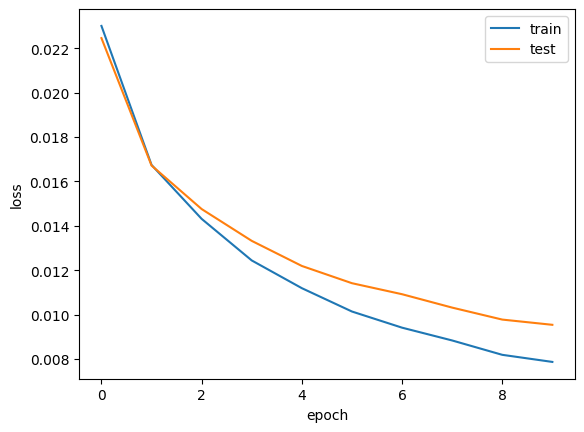

In [19]:
plt.plot(third_network.loss, label='train')
plt.plot(third_network.val_loss, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

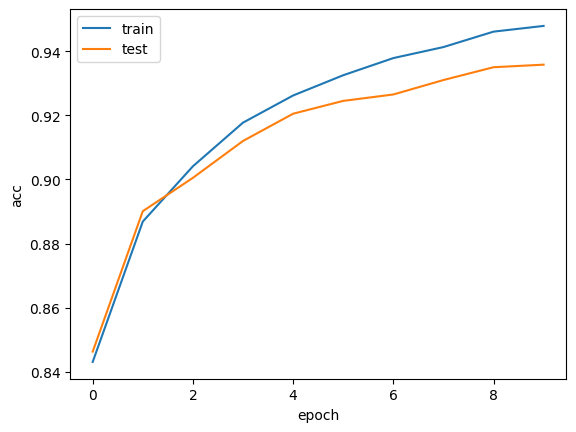

In [20]:
plt.plot(third_network.acc, label='train')
plt.plot(third_network.val_acc, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

## Fourth model

In [21]:
fourth_network = create_neu_network(neu_list = [28*28, 128, 64, 10], 
                                        activ_func_list=['relu', 'sigmoid', 'softmax'], 
                                        loss_func='categorical_crossentropy')
fourth_network.fit(train_images, train_labels, epochs=10, learning_rate=.01, val=(test_images, test_labels))

epoch: 1, loss: [0.31503452], acc: 0.9044333333333333
val_loss: [0.31624851], val_acc: 0.9034
epoch: 2, loss: [0.22660844], acc: 0.9319333333333333
val_loss: [0.23719215], val_acc: 0.9274
epoch: 3, loss: [0.18818564], acc: 0.94275
val_loss: [0.20150754], val_acc: 0.9396
epoch: 4, loss: [0.16972638], acc: 0.9483
val_loss: [0.19651088], val_acc: 0.9406
epoch: 5, loss: [0.14714791], acc: 0.9550833333333333
val_loss: [0.17080335], val_acc: 0.9481
epoch: 6, loss: [0.13356454], acc: 0.9584166666666667
val_loss: [0.15803753], val_acc: 0.9534
epoch: 7, loss: [0.11168008], acc: 0.9656666666666667
val_loss: [0.15056742], val_acc: 0.9576
epoch: 8, loss: [0.10913348], acc: 0.9661333333333333
val_loss: [0.14921857], val_acc: 0.957
epoch: 9, loss: [0.09506353], acc: 0.9704
val_loss: [0.14024581], val_acc: 0.9585
epoch: 10, loss: [0.08780465], acc: 0.9725166666666667
val_loss: [0.13762822], val_acc: 0.9595


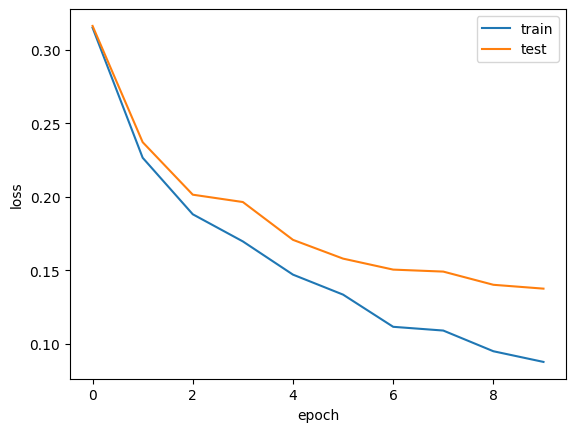

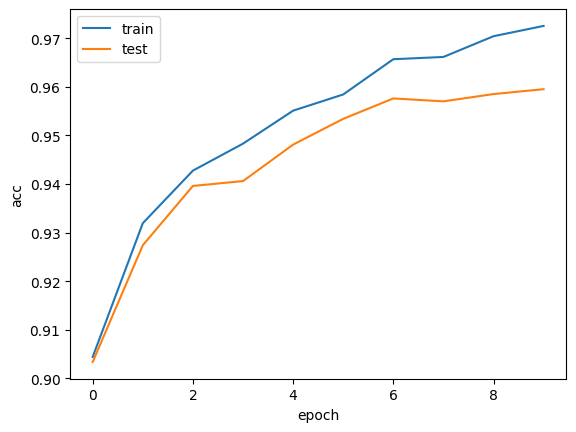

In [22]:
plt.plot(fourth_network.loss, label='train')
plt.plot(fourth_network.val_loss, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
plt.plot(fourth_network.acc, label='train')
plt.plot(fourth_network.val_acc, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()